Deconvolution with Fiji
===

This Jupyter notebook demonstrates the deconvolution groovy script with PyImageJ. Here the results (deconvolved image and PSF image) are directly accessible to Python.

First let's start PyImageJ (_note:_ We **do not need** plugins to perform deconvolution with ImageJ2. Here, I am initializaing only ImageJ2 and not Fiji).

In [1]:
import imagej
from matplotlib import pyplot as plt

# initialize ImageJ2
ij = imagej.init()
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.9.0/1.53t


This Groovy script will accept any 2D or 3D dataset and deconvolves it with a synthetic PSF.

In [2]:
decon_groovy_script = """
#@ ImgPlus img
#@ OpService ops
#@ UIService ui 
#@ Integer iterations(label="Iterations", value=30)
#@ Float numericalAperture(label="Numerical Aperture", value=1.4)
#@ Float wavelength(label="Wavelength (nm)", value=550)
#@ Float riImmersion(label="Refractive Index (immersion)", value=1.5)
#@ Float riSample(label="Refractive Index (sample)", value=1.4)
#@ Float xySpacing(label="XY Spacing (nm)", value=62.9)
#@ Float zSpacing(label="Z Spacing (nm)", value=160)
#@ Integer depth(value=0)
#@output ImgPlus psf
#@output ImgPlus result

import ij.IJ
import net.imglib2.FinalDimensions
import net.imglib2.type.numeric.real.FloatType

// convert input image to 32-bit
img_f = ops.convert().float32(img)

// generate synthetic psf based on input shape
psf_dims = []
for (dim in img.dimensionsAsLongArray()) {
    psf_dims.add(dim)
}
psf_size = new FinalDimensions(psf_dims as long[])
wv = wavelength * 1E-9
lateral_res = xySpacing * 1E-9
axial_res = zSpacing * 1E-9
psf = ops.create().kernelDiffraction(psf_size, numericalAperture, wv, riSample, riImmersion, lateral_res, axial_res, depth, new FloatType())

// deconvolve image
result = ops.deconvolve().richardsonLucy(img_f, psf, iterations)
"""

# load and run sample data
data = ij.io().open('../sample_data/sample_1.tif')
args = {"img": data.getImgPlus()}
result = ij.py.run_script("Groovy", decon_groovy_script, args)

# get script outputs (psf image and deconvolved image)
psf = ij.py.to_xarray(result.getOutput("psf"))
decon_img = ij.py.to_xarray(result.getOutput("result"))

Let's look at the results after running the script with PyImageJ:

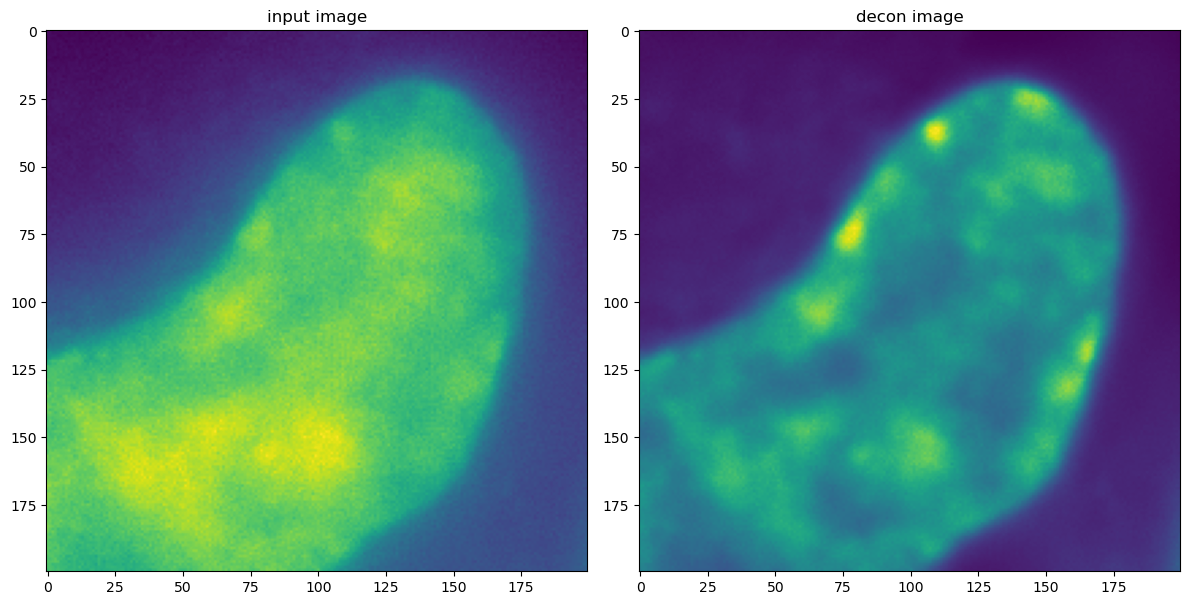

In [3]:
# display a slice of the input image with the deconvolved result
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].imshow(ij.py.to_xarray(data)[30, :, :])
ax[0].set_title("input image")
ax[1].imshow(decon_img[30, :, :])
ax[1].set_title("decon image")
plt.tight_layout()
plt.show()

We can also look at the synthetic PSF that ImageJ Ops generated.

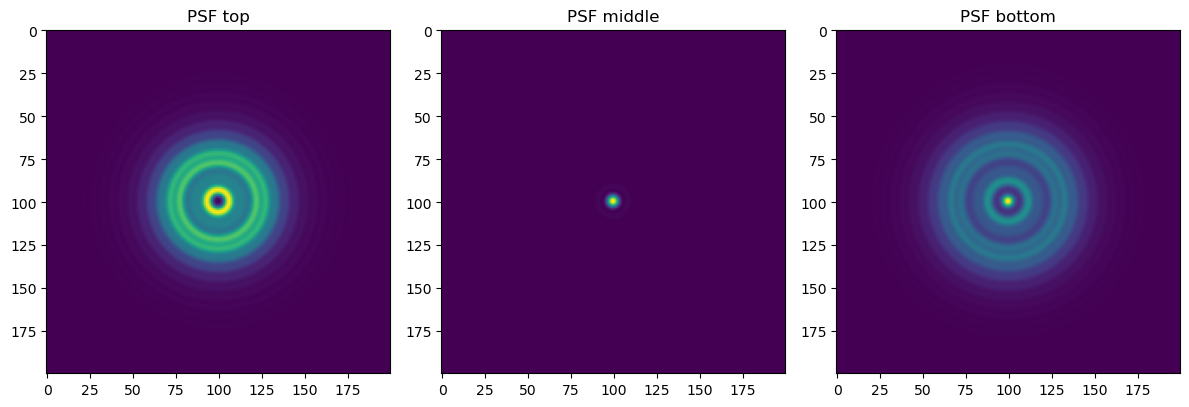

In [4]:
# display a slice of the input image with the deconvolved result
fig, ax = plt.subplots(1, 3, figsize=(12, 9))
ax[0].imshow(psf[5, :, :])
ax[0].set_title("PSF top")
ax[1].imshow(psf[30, :, :])
ax[1].set_title("PSF middle")
ax[2].imshow(psf[60, :, :])
ax[2].set_title("PSF bottom")
plt.tight_layout()
plt.show()

If you want the orthogonal view of the PSF you can easily do so by transposing the `Z` or `pln` axis to either the `X` or `Y` position. For example, an XZ projection:

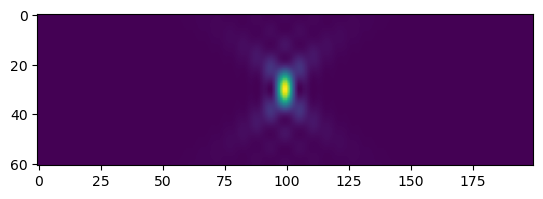

In [5]:
import xarray as xr

# transpose dim order from ("pln", "row", "col") to ("row", "pln", "col")
xz_psf = psf.data.transpose(1, 0, 2)
plt.imshow(xz_psf[102, :, :])